In [287]:
from dpm.distributions import Normal, LogNormal, Laplace, Logistic
from torch.nn import Linear, Module, NLLLoss
import numpy as np
from scipy.special import comb
import math
from torch.optim import Adam
import torch
import matplotlib.pyplot as plt

In [288]:
def function(x):
    return 4 * x + 5 + torch.randn((x.shape[0], 1))

def function_lap(x):
    return 4 * x + 5 + Laplace(learnable=False).sample(x.shape[0])

def function_bin(x):
    return torch.sigmoid(4*x - 20 + torch.randn((x.shape[0], 1))) >= 0.5

torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1])


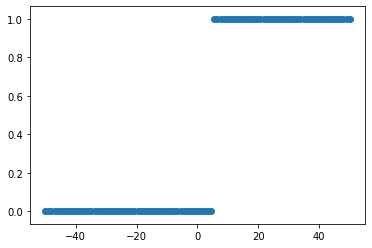

In [289]:
data = torch.tensor(np.linspace(-50, 50., 100)).float().reshape(-1, 1)
response = function(data)
response_lap = function_lap(data)
response_bin = function_bin(data)
print(data.size(), response.size(), response_lap.size(), response_bin.size())
plt.scatter(data, response_bin)

In [296]:
class GLM(Module):
    
    def __init__(self, dist, input_dim=1, output_dim=1):
        super().__init__()
        self.linear = Linear(input_dim, output_dim)
        self.dist = dist
        
    def log_prob(self, x, y):
        mu = self.mean(x)
        return torch.stack([self.dist(mu[i], learnable=False).log_prob(y[i].reshape(-1, 1)) 
                            for i in range(x.shape[0])])
    
    def mean(self, x):
        raise NotImplementedError()
    

class NormalGLM(GLM):
    
    def __init__(self, input_dim=1, output_dim=1):
        super().__init__(Normal)
        
    def mean(self, x):
        return self.linear(x)
    
    
    
class LaplaceGLM(GLM):
    
    def __init__(self, input_dim=1, output_dim=1):
        super().__init__(Laplace)
        
    def mean(self, x):
        return self.linear(x)
    
class Bernoulli(GLM):
    
    def __init__(self, input_dim=1, output_dim=1):
        super().__init__(Logistic)
        
    def mean(self, x):
        return torch.sigmoid(self.linear(x))
    
    
        

In [297]:
m = Bernoulli()
optimizer = Adam(m.parameters(), lr=0.01)

In [ ]:
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = -m.log_prob(data, response_lap).sum()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"[Epoch {epoch}/{epochs}]\tLoss {loss.item():.2f}")


[Epoch 0/1000]	Loss inf
[Epoch 100/1000]	Loss inf
[Epoch 200/1000]	Loss inf
[Epoch 300/1000]	Loss inf
[Epoch 400/1000]	Loss inf
[Epoch 500/1000]	Loss inf
[Epoch 600/1000]	Loss inf
[Epoch 700/1000]	Loss inf
[Epoch 800/1000]	Loss inf


In [ ]:
print(m.linear.weight)
print(m.linear.bias)